In [1]:
%cd /content/drive/MyDrive/ColabWork/PyTorchSegmentation

/content/drive/MyDrive/ColabWork/PyTorchSegmentation


In [3]:
!pip install -q torch_snippets pytorch_model_summary

     |████████████████████████████████| 61kB 4.4MB/s 
     |████████████████████████████████| 204kB 8.8MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 


In [4]:
import os
if not os.path.exists('dataset1'):
    !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
    !unzip -q dataset1.zip
    !rm dataset1.zip
    !pip install -q torch_snippets pytorch_model_summary

from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'

[04/06/21 14:59:03] WARNING  Not importing Lightning Report      ]8;id=1617721143.1676745-537248;file:///usr/local/lib/python3.7/dist-packages/torch_snippets/torch_loader.py\torch_loader.py]8;;\:<module>:233

                    WARNING  sklearn is not found. Skipping relevant  ]8;id=1617721143.7845895-30819;file:///usr/local/lib/python3.7/dist-packages/torch_snippets/__init__.py\__init__.py]8;;\:<module>:13
                             imports from submodule `sklegos`

In [5]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

In [6]:
class SegData(Dataset):
    def __init__(self, split):
        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split
    def __len__(self):
        return len(self.items)
    def __getitem__(self, ix):
        image = read(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.resize(image, (224,224))
        mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png')
        mask = cv2.resize(mask, (224,224))
        return image, mask
    def choose(self): return self[randint(len(self))]
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

In [7]:
trn_ds = SegData('train')
val_ds = SegData('test')
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)


[04/06/21 14:59:27] INFO     367 files found at                           ]8;id=1617721167.3501828-208304;file:///usr/local/lib/python3.7/dist-packages/torch_snippets/loader.py\loader.py]8;;\:stems:198
                             dataset1/images_prepped_train

[04/06/21 14:59:29] INFO     101 files found at                           ]8;id=1617721169.4083965-272483;file:///usr/local/lib/python3.7/dist-packages/torch_snippets/loader.py\loader.py]8;;\:stems:198
                             dataset1/images_prepped_test

In [7]:
show??

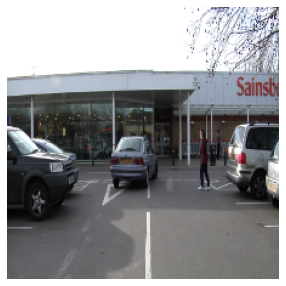

In [8]:
show(trn_ds[10][0])


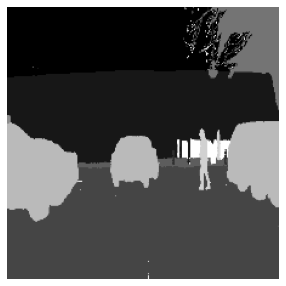

In [9]:
show(trn_ds[10][1])


In [9]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [10]:
from torchvision.models import vgg16_bn
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()

        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

In [12]:
Report??

In [11]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [12]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [13]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)

EPOCH: 1.000	trn_loss: 1.154	trn_acc: 0.735	val_loss: 0.784	val_acc: 0.833	(188.79s - 3586.98s remaining)
EPOCH: 2.000	trn_loss: 0.698	trn_acc: 0.819	val_loss: 0.564	val_acc: 0.860	(202.69s - 1824.19s remaining)
EPOCH: 3.000	trn_loss: 0.584	trn_acc: 0.843	val_loss: 0.539	val_acc: 0.856	(216.51s - 1226.87s remaining)
EPOCH: 4.000	trn_loss: 0.516	trn_acc: 0.858	val_loss: 0.544	val_acc: 0.859	(230.22s - 920.89s remaining)
EPOCH: 5.000	trn_loss: 0.465	trn_acc: 0.872	val_loss: 0.634	val_acc: 0.803	(244.00s - 732.01s remaining)
EPOCH: 6.000	trn_loss: 0.445	trn_acc: 0.875	val_loss: 0.486	val_acc: 0.864	(257.69s - 601.27s remaining)
EPOCH: 7.000	trn_loss: 0.425	trn_acc: 0.880	val_loss: 0.444	val_acc: 0.869	(271.49s - 504.19s remaining)
EPOCH: 8.000	trn_loss: 0.404	trn_acc: 0.885	val_loss: 0.482	val_acc: 0.847	(285.22s - 427.83s remaining)
EPOCH: 9.000	trn_loss: 0.386	trn_acc: 0.889	val_loss: 0.411	val_acc: 0.870	(298.93s - 365.36s remaining)
EPOCH: 10.000	trn_loss: 0.369	trn_acc: 0.894	val_los

100%|██████████| 121/121 [00:00<00:00, 1041.81it/s]


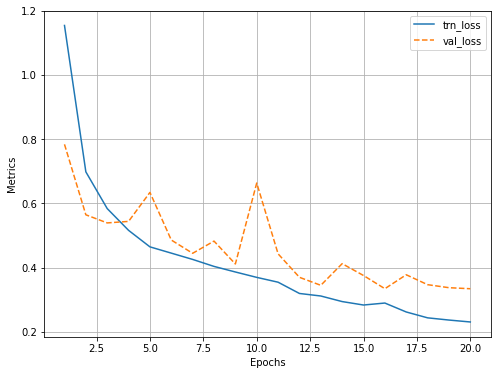

In [14]:
log.plot_epochs(['trn_loss','val_loss'])


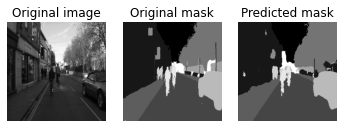

In [15]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])

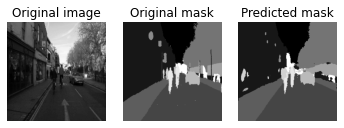

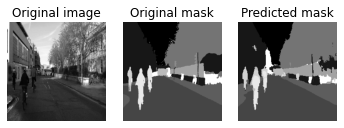

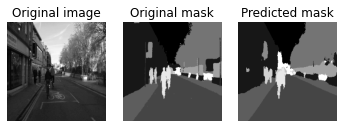

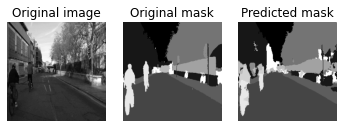

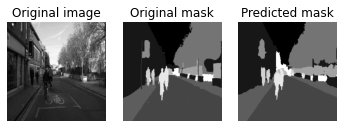

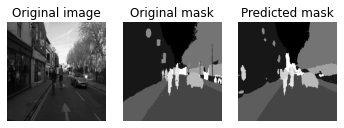

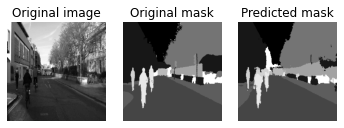

In [18]:

for i,(im,mask) in enumerate(val_dl):
  #im, mask = next(iter(val_dl))
  #im,mask=val_dl[20]
  _mask = model(im)
  _, _mask = torch.max(_mask, dim=1)
  subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
  ,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
  nc=3, titles=['Original image','Original mask','Predicted mask'])
  if i>5:
    break